## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

## Importing Dataset

In [2]:
warnings.filterwarnings('ignore')
TARGET = 'SalePrice'

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
df_ = pd.read_csv(r'rent.csv')
df = df_.copy()

## Task 1: Exploratory Data Analytics

### Step 1:  Examine the overall picture.

In [3]:
def check_df(dataframe, head = 5):

    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### nunique #####################")
    print(dataframe.nunique())

check_df(df)

##################### Shape #####################
(1460, 81)
##################### Types #####################
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object
##################### Head #####################
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0   1          60       RL         65.0  

### Step 2: Capture numeric and categorical variables.

In [4]:
def grab_col_names(dataframe, target, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.   

    Parameters
    ------
        dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables
        target: str
                Dependent (target) variable

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols_mask = [col for col in dataframe.columns if dataframe[col].dtypes == "O"
                     and dataframe[col].nunique() < car_th and col != target]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != "O"
                   and dataframe[col].nunique() < cat_th and col != target]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == "O" and
                   col not in cat_cols_mask and col != target]

    cat_cols = cat_cols_mask + num_but_cat

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"
                and col not in num_but_cat and col != target]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df, TARGET, cat_th=20)

Observations: 1460
Variables: 81
cat_cols: 57
num_cols: 22
cat_but_car: 1
num_but_cat: 15


### Step 3: Analyze numeric and categorical variables.

Numerical columns:

In [5]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0


count    1460.000000
mean      730.500000
std       421.610009
min         1.000000
25%       365.750000
50%       730.500000
75%      1095.250000
max      1460.000000
Name: Id, dtype: float64


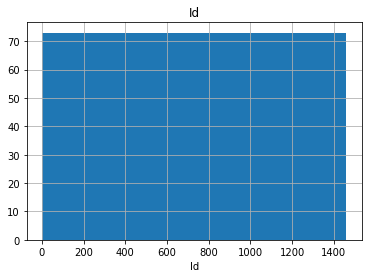

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64


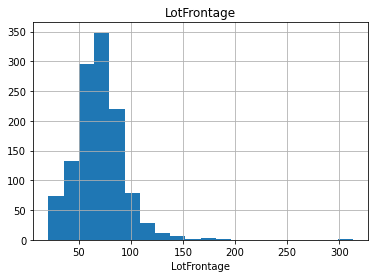

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64


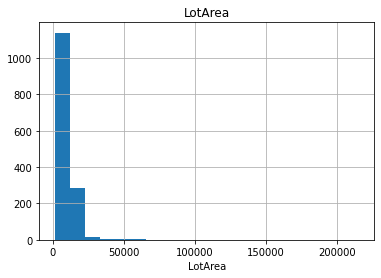

count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64


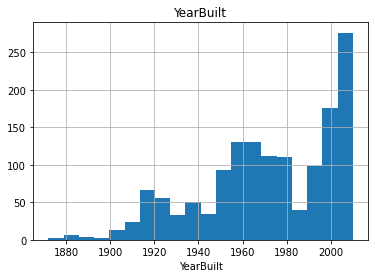

count    1460.000000
mean     1984.865753
std        20.645407
min      1950.000000
25%      1967.000000
50%      1994.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64


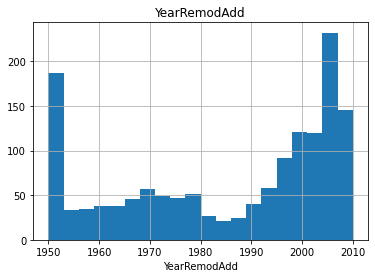

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64


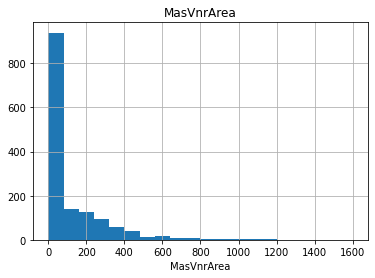

count    1460.000000
mean      443.639726
std       456.098091
min         0.000000
25%         0.000000
50%       383.500000
75%       712.250000
max      5644.000000
Name: BsmtFinSF1, dtype: float64


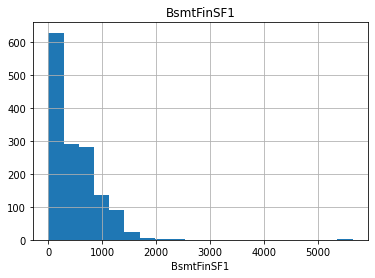

count    1460.000000
mean       46.549315
std       161.319273
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64


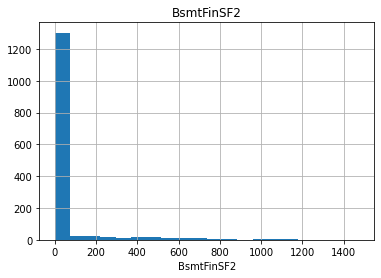

count    1460.000000
mean      567.240411
std       441.866955
min         0.000000
25%       223.000000
50%       477.500000
75%       808.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64


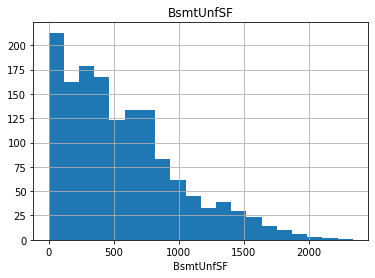

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64


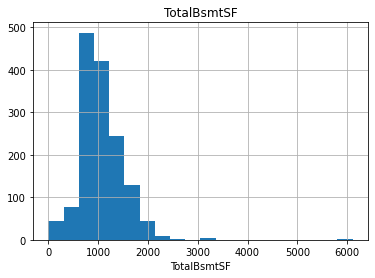

count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64


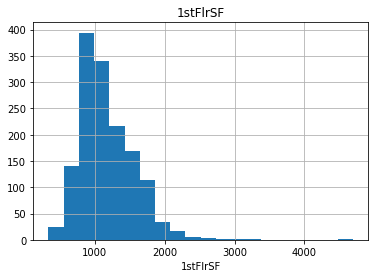

count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64


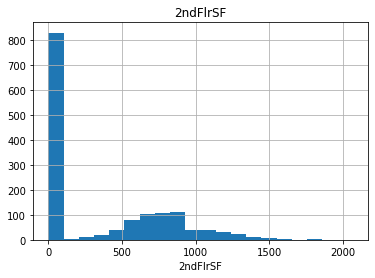

count    1460.000000
mean        5.844521
std        48.623081
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64


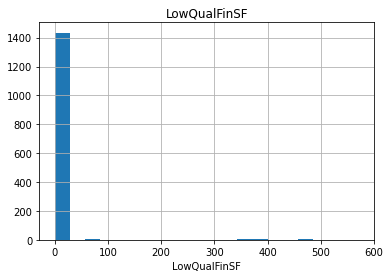

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64


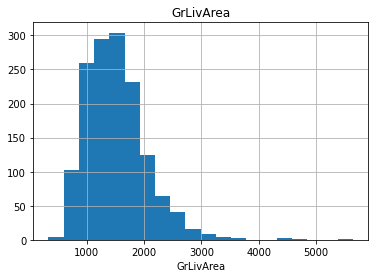

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64


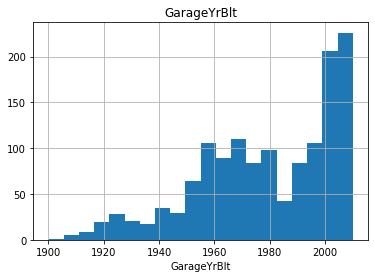

count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64


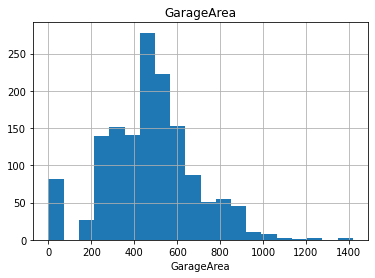

count    1460.000000
mean       94.244521
std       125.338794
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64


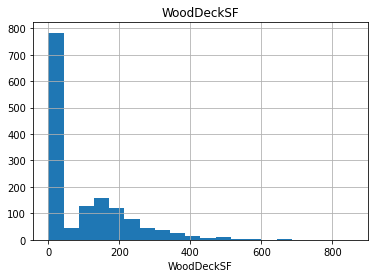

count    1460.000000
mean       46.660274
std        66.256028
min         0.000000
25%         0.000000
50%        25.000000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64


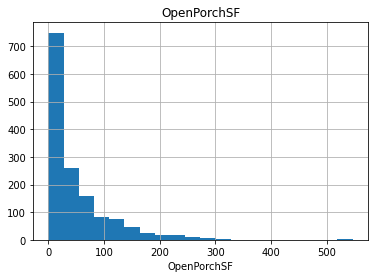

count    1460.000000
mean       21.954110
std        61.119149
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       552.000000
Name: EnclosedPorch, dtype: float64


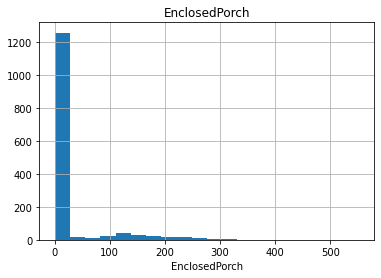

count    1460.000000
mean        3.409589
std        29.317331
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64


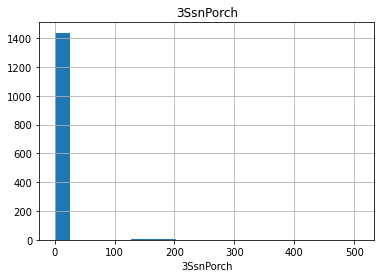

count    1460.000000
mean       15.060959
std        55.757415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64


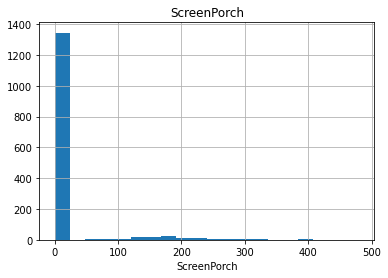

count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64


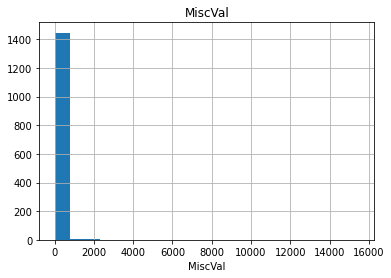

In [6]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.25, 0.50, 0.75]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

Categorical columns:

In [7]:
df[cat_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.0,50.0,70.0,190.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.0,6.0,7.0,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.0,5.0,6.0,9.0
BsmtFullBath,1460.0,0.425342,0.518911,0.0,0.0,0.0,1.0,3.0
BsmtHalfBath,1460.0,0.057534,0.238753,0.0,0.0,0.0,0.0,2.0
FullBath,1460.0,1.565068,0.550916,0.0,1.0,2.0,2.0,3.0
HalfBath,1460.0,0.382877,0.502885,0.0,0.0,0.0,1.0,2.0
BedroomAbvGr,1460.0,2.866438,0.815778,0.0,2.0,3.0,3.0,8.0
KitchenAbvGr,1460.0,1.046575,0.220338,0.0,1.0,1.0,1.0,3.0
TotRmsAbvGrd,1460.0,6.517808,1.625393,2.0,5.0,6.0,7.0,14.0


         MSZoning      Ratio
RL           1151  78.835616
RM            218  14.931507
FV             65   4.452055
RH             16   1.095890
C (all)        10   0.684932
##########################################


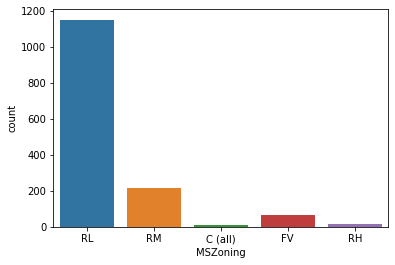

      Street      Ratio
Pave    1454  99.589041
Grvl       6   0.410959
##########################################


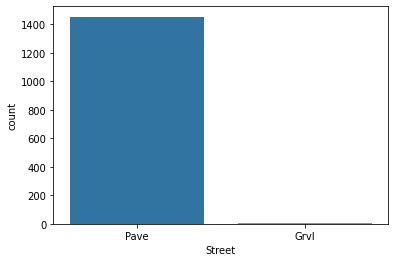

      Alley     Ratio
Grvl     50  3.424658
Pave     41  2.808219
##########################################


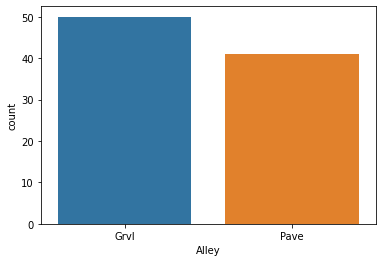

     LotShape      Ratio
Reg       925  63.356164
IR1       484  33.150685
IR2        41   2.808219
IR3        10   0.684932
##########################################


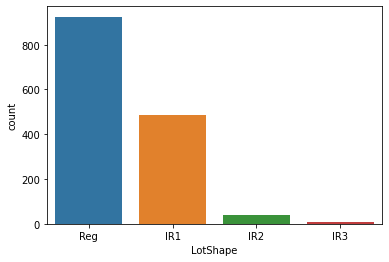

     LandContour      Ratio
Lvl         1311  89.794521
Bnk           63   4.315068
HLS           50   3.424658
Low           36   2.465753
##########################################


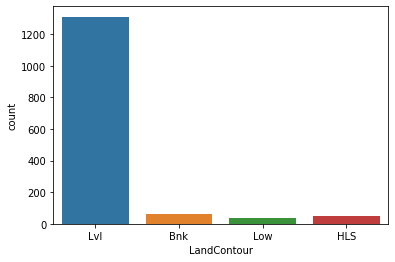

        Utilities      Ratio
AllPub       1459  99.931507
NoSeWa          1   0.068493
##########################################


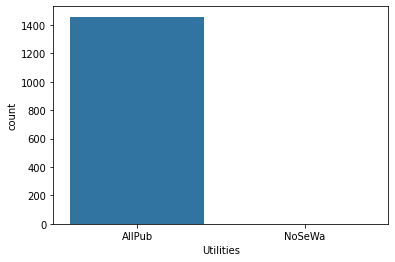

         LotConfig      Ratio
Inside        1052  72.054795
Corner         263  18.013699
CulDSac         94   6.438356
FR2             47   3.219178
FR3              4   0.273973
##########################################


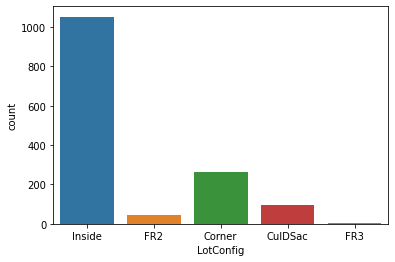

     LandSlope      Ratio
Gtl       1382  94.657534
Mod         65   4.452055
Sev         13   0.890411
##########################################


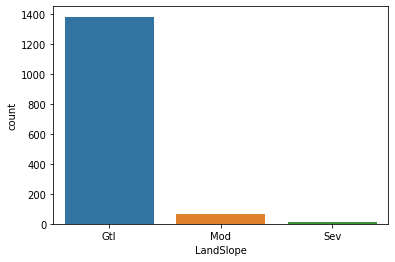

        Condition1      Ratio
Norm          1260  86.301370
Feedr           81   5.547945
Artery          48   3.287671
RRAn            26   1.780822
PosN            19   1.301370
RRAe            11   0.753425
PosA             8   0.547945
RRNn             5   0.342466
RRNe             2   0.136986
##########################################


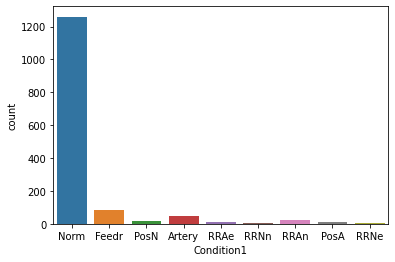

        Condition2      Ratio
Norm          1445  98.972603
Feedr            6   0.410959
Artery           2   0.136986
RRNn             2   0.136986
PosN             2   0.136986
PosA             1   0.068493
RRAn             1   0.068493
RRAe             1   0.068493
##########################################


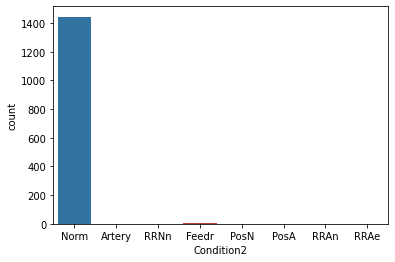

        BldgType      Ratio
1Fam        1220  83.561644
TwnhsE       114   7.808219
Duplex        52   3.561644
Twnhs         43   2.945205
2fmCon        31   2.123288
##########################################


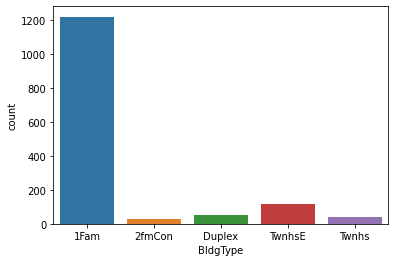

        HouseStyle      Ratio
1Story         726  49.726027
2Story         445  30.479452
1.5Fin         154  10.547945
SLvl            65   4.452055
SFoyer          37   2.534247
1.5Unf          14   0.958904
2.5Unf          11   0.753425
2.5Fin           8   0.547945
##########################################


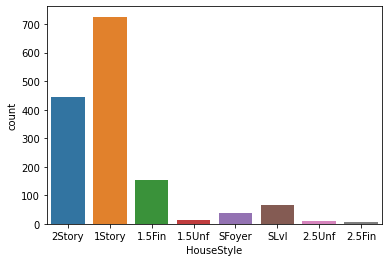

         RoofStyle      Ratio
Gable         1141  78.150685
Hip            286  19.589041
Flat            13   0.890411
Gambrel         11   0.753425
Mansard          7   0.479452
Shed             2   0.136986
##########################################


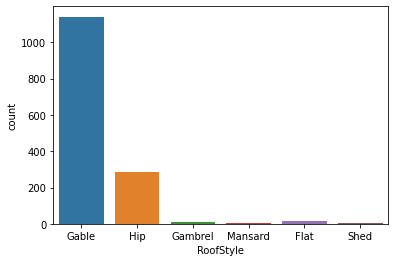

         RoofMatl      Ratio
CompShg      1434  98.219178
Tar&Grv        11   0.753425
WdShngl         6   0.410959
WdShake         5   0.342466
Metal           1   0.068493
Membran         1   0.068493
Roll            1   0.068493
ClyTile         1   0.068493
##########################################


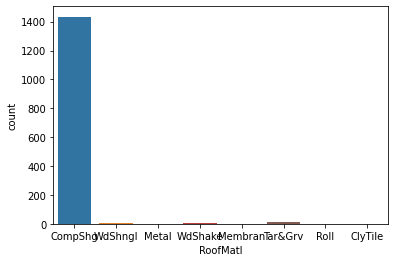

         Exterior1st      Ratio
VinylSd          515  35.273973
HdBoard          222  15.205479
MetalSd          220  15.068493
Wd Sdng          206  14.109589
Plywood          108   7.397260
CemntBd           61   4.178082
BrkFace           50   3.424658
WdShing           26   1.780822
Stucco            25   1.712329
AsbShng           20   1.369863
BrkComm            2   0.136986
Stone              2   0.136986
AsphShn            1   0.068493
ImStucc            1   0.068493
CBlock             1   0.068493
##########################################


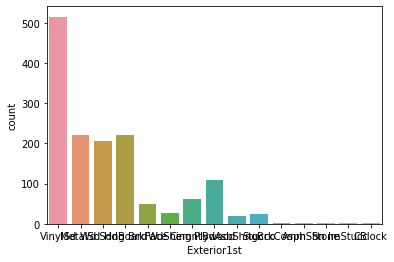

         Exterior2nd      Ratio
VinylSd          504  34.520548
MetalSd          214  14.657534
HdBoard          207  14.178082
Wd Sdng          197  13.493151
Plywood          142   9.726027
CmentBd           60   4.109589
Wd Shng           38   2.602740
Stucco            26   1.780822
BrkFace           25   1.712329
AsbShng           20   1.369863
ImStucc           10   0.684932
Brk Cmn            7   0.479452
Stone              5   0.342466
AsphShn            3   0.205479
Other              1   0.068493
CBlock             1   0.068493
##########################################


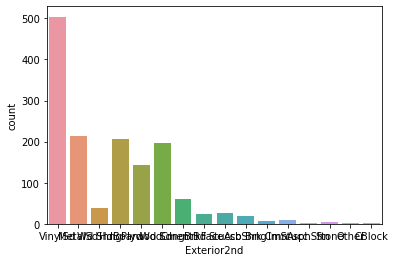

         MasVnrType      Ratio
None            864  59.178082
BrkFace         445  30.479452
Stone           128   8.767123
BrkCmn           15   1.027397
##########################################


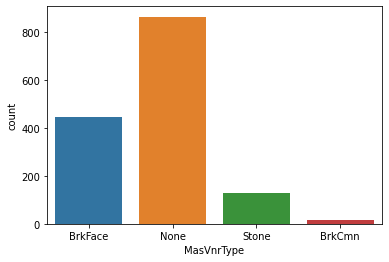

    ExterQual      Ratio
TA        906  62.054795
Gd        488  33.424658
Ex         52   3.561644
Fa         14   0.958904
##########################################


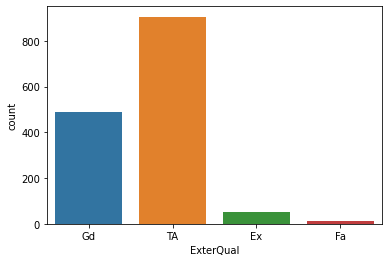

    ExterCond      Ratio
TA       1282  87.808219
Gd        146  10.000000
Fa         28   1.917808
Ex          3   0.205479
Po          1   0.068493
##########################################


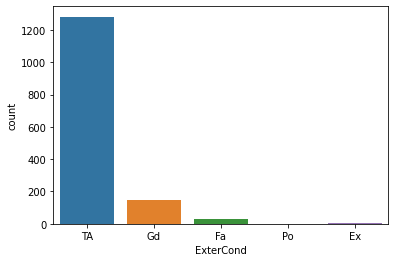

        Foundation      Ratio
PConc          647  44.315068
CBlock         634  43.424658
BrkTil         146  10.000000
Slab            24   1.643836
Stone            6   0.410959
Wood             3   0.205479
##########################################


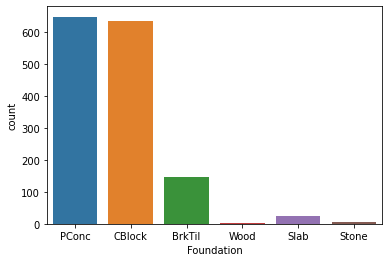

    BsmtQual      Ratio
TA       649  44.452055
Gd       618  42.328767
Ex       121   8.287671
Fa        35   2.397260
##########################################


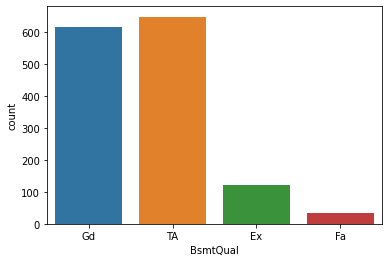

    BsmtCond      Ratio
TA      1311  89.794521
Gd        65   4.452055
Fa        45   3.082192
Po         2   0.136986
##########################################


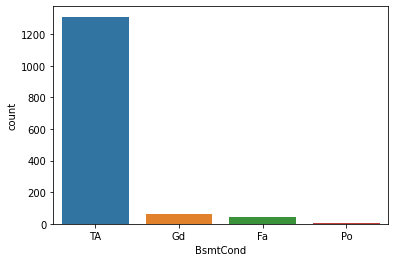

    BsmtExposure      Ratio
No           953  65.273973
Av           221  15.136986
Gd           134   9.178082
Mn           114   7.808219
##########################################


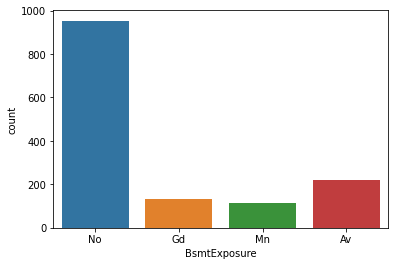

     BsmtFinType1      Ratio
Unf           430  29.452055
GLQ           418  28.630137
ALQ           220  15.068493
BLQ           148  10.136986
Rec           133   9.109589
LwQ            74   5.068493
##########################################


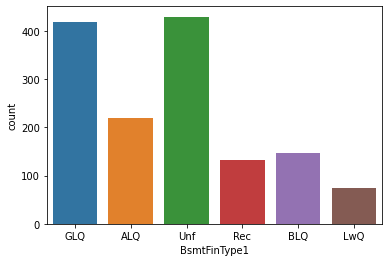

     BsmtFinType2      Ratio
Unf          1256  86.027397
Rec            54   3.698630
LwQ            46   3.150685
BLQ            33   2.260274
ALQ            19   1.301370
GLQ            14   0.958904
##########################################


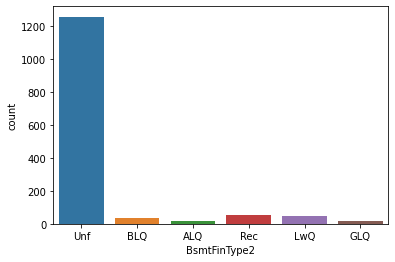

       Heating      Ratio
GasA      1428  97.808219
GasW        18   1.232877
Grav         7   0.479452
Wall         4   0.273973
OthW         2   0.136986
Floor        1   0.068493
##########################################


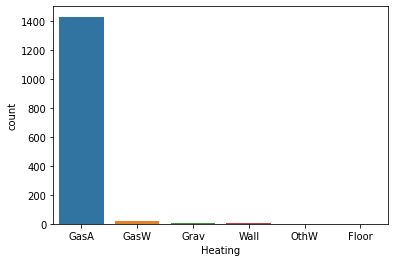

    HeatingQC      Ratio
Ex        741  50.753425
TA        428  29.315068
Gd        241  16.506849
Fa         49   3.356164
Po          1   0.068493
##########################################


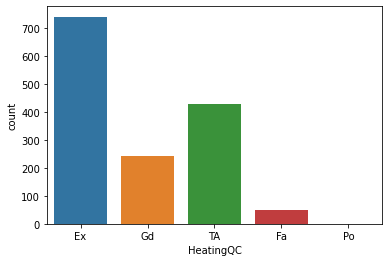

   CentralAir      Ratio
Y        1365  93.493151
N          95   6.506849
##########################################


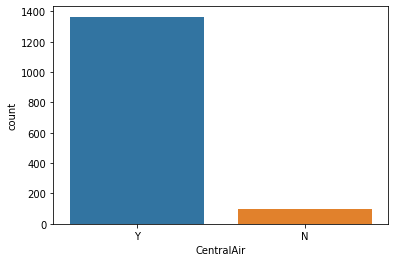

       Electrical      Ratio
SBrkr        1334  91.369863
FuseA          94   6.438356
FuseF          27   1.849315
FuseP           3   0.205479
Mix             1   0.068493
##########################################


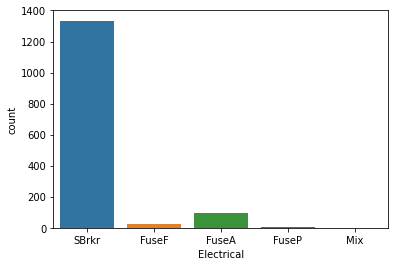

    KitchenQual      Ratio
TA          735  50.342466
Gd          586  40.136986
Ex          100   6.849315
Fa           39   2.671233
##########################################


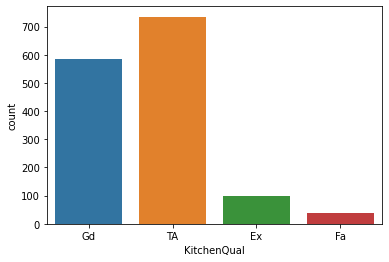

      Functional      Ratio
Typ         1360  93.150685
Min2          34   2.328767
Min1          31   2.123288
Mod           15   1.027397
Maj1          14   0.958904
Maj2           5   0.342466
Sev            1   0.068493
##########################################


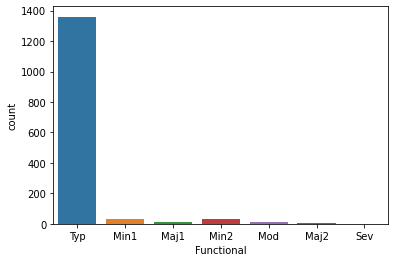

    FireplaceQu      Ratio
Gd          380  26.027397
TA          313  21.438356
Fa           33   2.260274
Ex           24   1.643836
Po           20   1.369863
##########################################


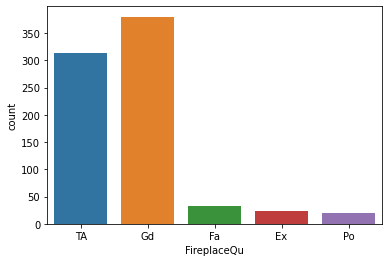

         GarageType      Ratio
Attchd          870  59.589041
Detchd          387  26.506849
BuiltIn          88   6.027397
Basment          19   1.301370
CarPort           9   0.616438
2Types            6   0.410959
##########################################


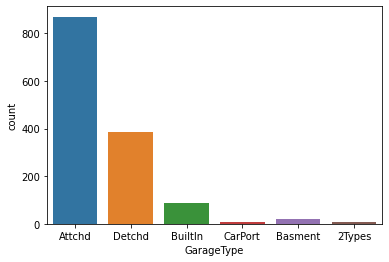

     GarageFinish      Ratio
Unf           605  41.438356
RFn           422  28.904110
Fin           352  24.109589
##########################################


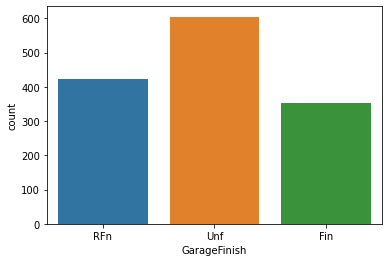

    GarageQual      Ratio
TA        1311  89.794521
Fa          48   3.287671
Gd          14   0.958904
Ex           3   0.205479
Po           3   0.205479
##########################################


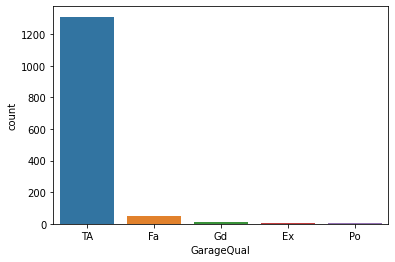

    GarageCond      Ratio
TA        1326  90.821918
Fa          35   2.397260
Gd           9   0.616438
Po           7   0.479452
Ex           2   0.136986
##########################################


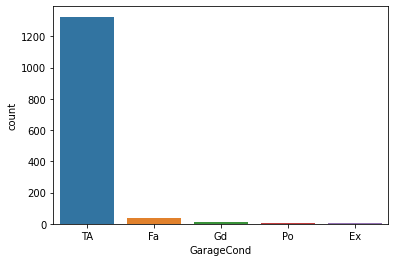

   PavedDrive      Ratio
Y        1340  91.780822
N          90   6.164384
P          30   2.054795
##########################################


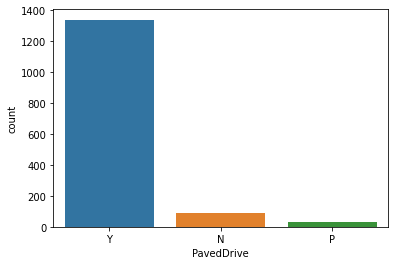

    PoolQC     Ratio
Gd       3  0.205479
Ex       2  0.136986
Fa       2  0.136986
##########################################


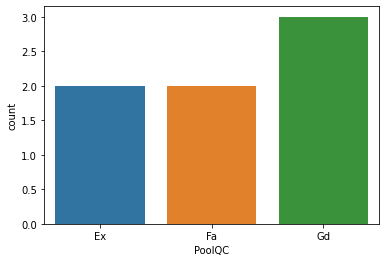

       Fence      Ratio
MnPrv    157  10.753425
GdPrv     59   4.041096
GdWo      54   3.698630
MnWw      11   0.753425
##########################################


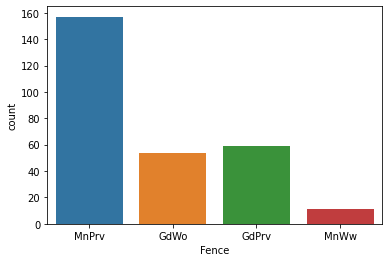

      MiscFeature     Ratio
Shed           49  3.356164
Gar2            2  0.136986
Othr            2  0.136986
TenC            1  0.068493
##########################################


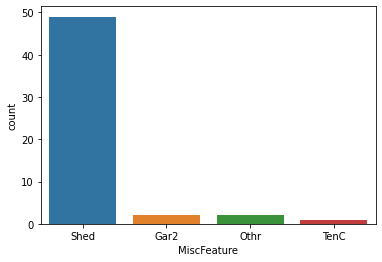

       SaleType      Ratio
WD         1267  86.780822
New         122   8.356164
COD          43   2.945205
ConLD         9   0.616438
ConLI         5   0.342466
ConLw         5   0.342466
CWD           4   0.273973
Oth           3   0.205479
Con           2   0.136986
##########################################


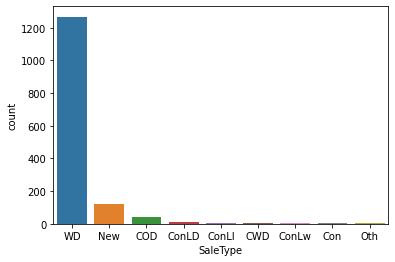

         SaleCondition      Ratio
Normal            1198  82.054795
Partial            125   8.561644
Abnorml            101   6.917808
Family              20   1.369863
Alloca              12   0.821918
AdjLand              4   0.273973
##########################################


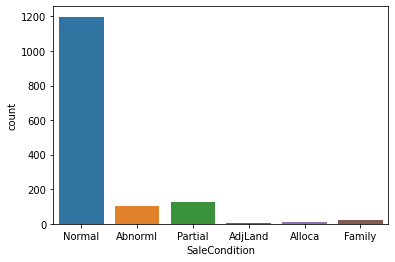

     MSSubClass      Ratio
20          536  36.712329
60          299  20.479452
50          144   9.863014
120          87   5.958904
30           69   4.726027
160          63   4.315068
70           60   4.109589
80           58   3.972603
90           52   3.561644
190          30   2.054795
85           20   1.369863
75           16   1.095890
45           12   0.821918
180          10   0.684932
40            4   0.273973
##########################################


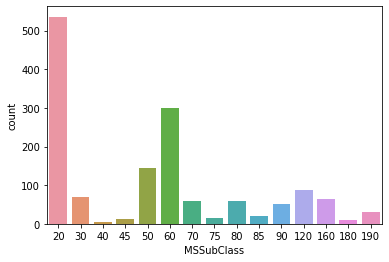

    OverallQual      Ratio
5           397  27.191781
6           374  25.616438
7           319  21.849315
8           168  11.506849
4           116   7.945205
9            43   2.945205
3            20   1.369863
10           18   1.232877
2             3   0.205479
1             2   0.136986
##########################################


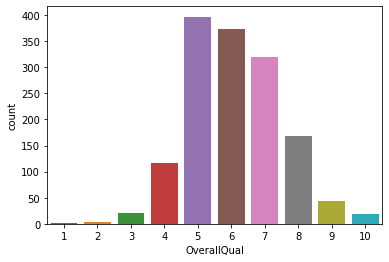

   OverallCond      Ratio
5          821  56.232877
6          252  17.260274
7          205  14.041096
8           72   4.931507
4           57   3.904110
3           25   1.712329
9           22   1.506849
2            5   0.342466
1            1   0.068493
##########################################


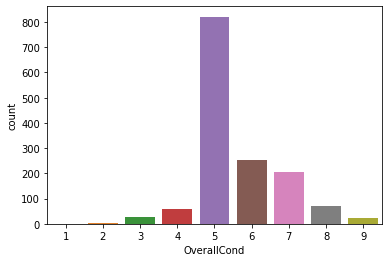

   BsmtFullBath      Ratio
0           856  58.630137
1           588  40.273973
2            15   1.027397
3             1   0.068493
##########################################


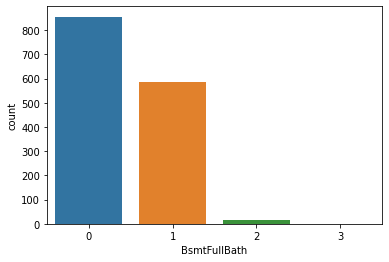

   BsmtHalfBath      Ratio
0          1378  94.383562
1            80   5.479452
2             2   0.136986
##########################################


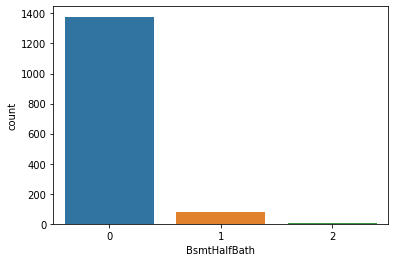

   FullBath      Ratio
2       768  52.602740
1       650  44.520548
3        33   2.260274
0         9   0.616438
##########################################


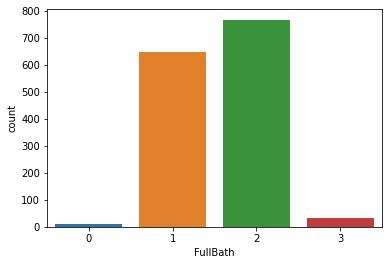

   HalfBath      Ratio
0       913  62.534247
1       535  36.643836
2        12   0.821918
##########################################


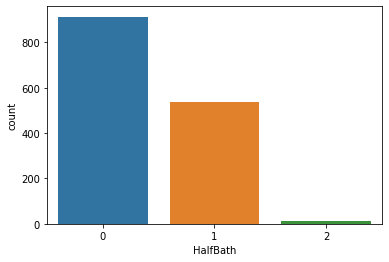

   BedroomAbvGr      Ratio
3           804  55.068493
2           358  24.520548
4           213  14.589041
1            50   3.424658
5            21   1.438356
6             7   0.479452
0             6   0.410959
8             1   0.068493
##########################################


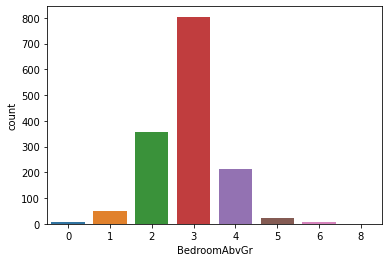

   KitchenAbvGr      Ratio
1          1392  95.342466
2            65   4.452055
3             2   0.136986
0             1   0.068493
##########################################


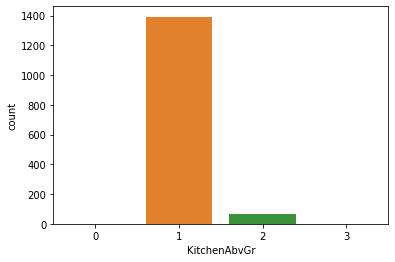

    TotRmsAbvGrd      Ratio
6            402  27.534247
7            329  22.534247
5            275  18.835616
8            187  12.808219
4             97   6.643836
9             75   5.136986
10            47   3.219178
11            18   1.232877
3             17   1.164384
12            11   0.753425
2              1   0.068493
14             1   0.068493
##########################################


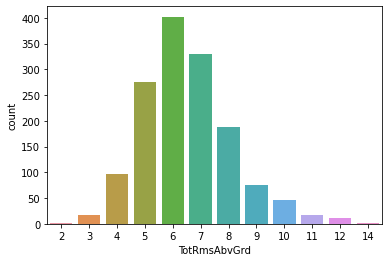

   Fireplaces      Ratio
0         690  47.260274
1         650  44.520548
2         115   7.876712
3           5   0.342466
##########################################


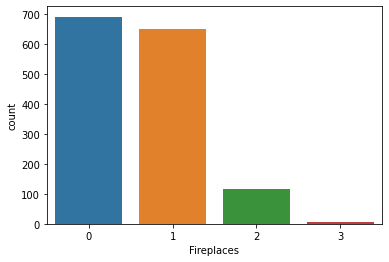

   GarageCars      Ratio
2         824  56.438356
1         369  25.273973
3         181  12.397260
0          81   5.547945
4           5   0.342466
##########################################


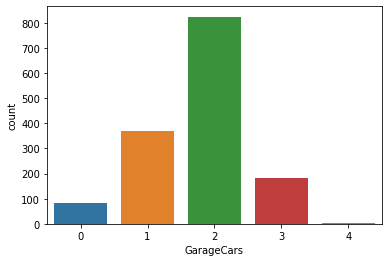

     PoolArea      Ratio
0        1453  99.520548
512         1   0.068493
648         1   0.068493
576         1   0.068493
555         1   0.068493
480         1   0.068493
519         1   0.068493
738         1   0.068493
##########################################


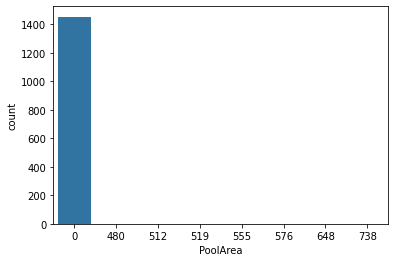

    MoSold      Ratio
6      253  17.328767
7      234  16.027397
5      204  13.972603
4      141   9.657534
8      122   8.356164
3      106   7.260274
10      89   6.095890
11      79   5.410959
9       63   4.315068
12      59   4.041096
1       58   3.972603
2       52   3.561644
##########################################


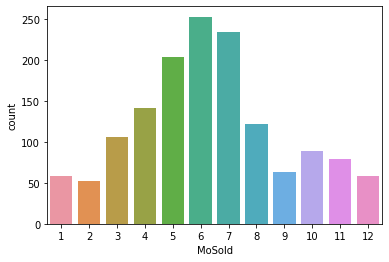

      YrSold      Ratio
2009     338  23.150685
2007     329  22.534247
2006     314  21.506849
2008     304  20.821918
2010     175  11.986301
##########################################


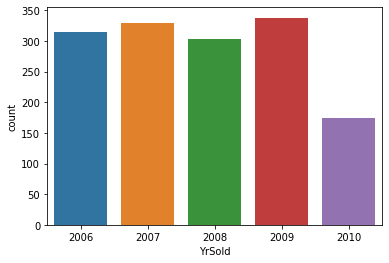

In [8]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

## Task 2: Data Pre-Processing

### Step 1: Analyze and handle missing observations.

In [9]:
def missing_values_table(dataframe, na_name=False):
    '''
    This Python function, missing_values_table, is designed to provide a summary of missing values in a DataFrame

    Parameters:
    dataframe: The DataFrame for which you want to analyze missing values.
    na_name (default False): A boolean flag that, when set to True, returns a list of column names with missing values.
    '''
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [10]:
features_with_missing = missing_values_table(df, na_name=True)

              n_miss  ratio
PoolQC          1453  99.52
MiscFeature     1406  96.30
Alley           1369  93.77
Fence           1179  80.75
FireplaceQu      690  47.26
LotFrontage      259  17.74
GarageType        81   5.55
GarageYrBlt       81   5.55
GarageFinish      81   5.55
GarageQual        81   5.55
GarageCond        81   5.55
BsmtExposure      38   2.60
BsmtFinType2      38   2.60
BsmtFinType1      37   2.53
BsmtCond          37   2.53
BsmtQual          37   2.53
MasVnrArea         8   0.55
MasVnrType         8   0.55
Electrical         1   0.07


For the following variables, missing data means that the relevant attribute does not exist, so missing data was replaced with 'NA'.

In [11]:
df['PoolQC'].fillna('NA', inplace=True)
df['Fence'].fillna('NA', inplace=True)
df['MiscFeature'].fillna('None', inplace=True)
df['Alley'].fillna('NA', inplace=True)
df['FireplaceQu'].fillna('NA', inplace=True)
df['GarageType'].fillna('NA', inplace=True)
df['GarageYrBlt'].fillna(0, inplace=True)
df['GarageFinish'].fillna('NA', inplace=True)
df['GarageQual'].fillna('NA', inplace=True)
df['GarageCond'].fillna('NA', inplace=True)
df['BsmtCond'].fillna('NA', inplace=True)
df['BsmtQual'].fillna('NA', inplace=True)
df['BsmtExposure'].fillna('NA', inplace=True)
df['BsmtFinType2'].fillna('NA', inplace=True)
df['BsmtFinType1'].fillna('NA', inplace=True)
df['MasVnrType'].fillna('NA', inplace=True)
df['MasVnrArea'].fillna(0, inplace=True)

Observations with missing data were discarded directly from the Data Set as there were not many missing values.

In [12]:
df.drop(df[df['Electrical'].isnull()].index, inplace=True)
df.drop(df[df['LotFrontage'].isnull()].index, inplace=True)

### Step 2: Conduct outlier analysis and handle them.

In [13]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    '''
    This function calculates the lower and upper bounds for identifying outliers in a specified column of a DataFrame.

    Parameters:
    dataframe: The DataFrame containing the data.
    col_name: The name of the column for which you want to calculate outlier thresholds.
    q1 (default 0.25): The lower quartile (25th percentile) value used to calculate the lower limit.
    q3 (default 0.75): The upper quartile (75th percentile) value used to calculate the upper limit.
    '''

    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name, print_values=False):
    '''
    This function checks for outliers in a specified column of a DataFrame using the thresholds calculated by the outlier_thresholds function.

    Parameters:
    dataframe: The DataFrame containing the data.
    col_name: The name of the column to check for outliers.
    print_values (default False): A boolean flag indicating whether to print the actual outlier values if any are found.
    '''

    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95)
    if dataframe[(dataframe[col_name] > up_limit) |
                 (dataframe[col_name] < low_limit)].any(axis=None):
        if print_values:
            print(f'Values with higher values than upper limit in {col_name}:\n'
                  f'{dataframe.loc[dataframe[col_name] > up_limit, col_name]}\n')
            print(f'Values with lower values than lower limit in {col_name}:\n'
                  f'{dataframe.loc[dataframe[col_name] < low_limit, col_name]}\n',)
        else:
            print(f'There is outlined data in {col_name}')
        return True
    else:
        print(f'There is no outlined data in {col_name}')
        return False

In [14]:
for col in df[num_cols].columns:
    check_outlier(df, col, print_values=True)

There is no outlined data in Id
Values with higher values than upper limit in LotFrontage:
934     313.0
1298    313.0
Name: LotFrontage, dtype: float64

Values with lower values than lower limit in LotFrontage:
Series([], Name: LotFrontage, dtype: float64)

Values with higher values than upper limit in LotArea:
53       50271
271      39104
313     215245
451      70761
523      40094
661      46589
769      53504
848      45600
1169     35760
1298     63887
Name: LotArea, dtype: int64

Values with lower values than lower limit in LotArea:
Series([], Name: LotArea, dtype: int64)

There is no outlined data in YearBuilt
There is no outlined data in YearRemodAdd
Values with higher values than upper limit in MasVnrArea:
297     1600.0
691     1170.0
1169    1378.0
Name: MasVnrArea, dtype: float64

Values with lower values than lower limit in MasVnrArea:
Series([], Name: MasVnrArea, dtype: float64)

Values with higher values than upper limit in BsmtFinSF1:
1298    5644
Name: BsmtFinSF1, dt

Outliers could be suppressed to quartiles.

In [15]:
for col in df[num_cols]:
    low_limit, up_limit = outlier_thresholds(df, col, q1=0.05, q3=0.95)
    df.loc[df[col] > up_limit, col] = up_limit
    df.loc[df[col] < low_limit, col] = low_limit

### Step 3: Label Encoding

Defining ordinal variables to avoid encoding

In [16]:
ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

Binary encoding

In [17]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

One hot encoding

In [18]:
for col in cat_cols:
    if col not in binary_cols and ordinal_cols:
        df = pd.get_dummies(df, columns=[col], drop_first=True)

### Step 4: Standardization of numeric features.

In [19]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

## Task 3: Machine Learning Model Process

### Step 1: Chosing the best Machine Learning model for the data-set:

In [20]:
y = df[TARGET]
X = df.drop([TARGET, 'Neighborhood'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=33)

for alg in [LinearRegression, GradientBoostingRegressor, RandomForestRegressor, LGBMRegressor, CatBoostRegressor, XGBRegressor]:

    model = alg()
    if alg == CatBoostRegressor:
        model = alg(verbose=False)
    cv_result = np.mean(np.sqrt(-cross_val_score(model,
                                 X_train,
                                 y_train,
                                 cv=10,
                                 scoring="neg_mean_squared_error")))

    print(f'RMSE of {type(model).__name__}: {cv_result}')

RMSE of LinearRegression: 1654289555024730.2
RMSE of GradientBoostingRegressor: 30017.632895416453
RMSE of RandomForestRegressor: 33695.32823882239
RMSE of LGBMRegressor: 31958.258587924203
RMSE of CatBoostRegressor: 30412.979358059296
RMSE of XGBRegressor: 33191.21415290331


### Step 2: Fine tuning on best model

In [21]:
param_grid = {
    'num_leaves': [20, 31, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 5, 10],
    'min_child_samples': [20, 30, 50]
}

grid_search = GridSearchCV(estimator=LGBMRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_lgbm = grid_search.best_estimator_

In [22]:
best_params

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_samples': 20,
 'n_estimators': 500,
 'num_leaves': 31}

In [23]:
np.mean(np.sqrt(-cross_val_score(best_lgbm,
                                 X_train,
                                 y_train,
                                 cv=10,
                                 scoring="neg_mean_squared_error")))

31583.175092559093

Test scores of tuned model:

In [24]:
y_pred = best_lgbm.predict(X_test)

print(f'mse: {mean_squared_error(y_test, y_pred)}')
print(f'rmse: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'mae: {mean_absolute_error(y_test, y_pred)}')
print(f'r_squared: {r2_score(y_test, y_pred)}')

mse: 796321558.7418463
rmse: 28219.170057637173
mae: 18240.673135310306
r_squared: 0.8834251688877623
